This notebook focuses on trying to find a way to segment cells within organoids properly.
The end goals is to segment cell and extract morphology features from cellprofiler.
These masks must be imported into cellprofiler to extract features.

In [1]:
import argparse
import pathlib

import matplotlib.pyplot as plt

# Import dependencies
import numpy as np
import pandas as pd
import skimage
import tifffile
import torch
import tqdm
from cellpose import models
from csbdeep.utils import normalize
from PIL import Image
from stardist.plot import render_label

# check if in a jupyter notebook
try:
    cfg = get_ipython().config
    in_notebook = True
except NameError:
    in_notebook = False

print(in_notebook)

True


In [2]:
if not in_notebook:
    # set up arg parser
    parser = argparse.ArgumentParser(description="Segment the nuclei of a tiff image")

    parser.add_argument(
        "--input_dir",
        type=str,
        help="Path to the input directory containing the tiff images",
    )

    parser.add_argument(
        "--clip_limit",
        type=float,
        help="Clip limit for the adaptive histogram equalization",
    )

    args = parser.parse_args()
    clip_limit = args.clip_limit
    input_dir = pathlib.Path(args.input_dir).resolve(strict=True)

else:
    input_dir = pathlib.Path(
        "../../2.cellprofiler_ic_processing/illum_directory_test/"
    ).resolve(strict=True)
    clip_limit = 0.6

list_of_input_dirs = list(input_dir.glob("*"))
list_of_input_dirs = [x for x in list_of_input_dirs if x.is_dir()]
print(list_of_input_dirs)

figures_dir = pathlib.Path("../figures").resolve()
figures_dir.mkdir(exist_ok=True, parents=True)

[PosixPath('/home/lippincm/Documents/live_cell_timelapse_apoptosis/2.cellprofiler_ic_processing/illum_directory_test/20231017ChromaLive_endpoint_w_AnnexinV_2ch_MaxIP_C-04_F0001'), PosixPath('/home/lippincm/Documents/live_cell_timelapse_apoptosis/2.cellprofiler_ic_processing/illum_directory_test/20231017ChromaLive_endpoint_w_AnnexinV_2ch_MaxIP_C-03_F0001'), PosixPath('/home/lippincm/Documents/live_cell_timelapse_apoptosis/2.cellprofiler_ic_processing/illum_directory_test/20231017ChromaLive_6hr_4ch_MaxIP_C-04_F0001'), PosixPath('/home/lippincm/Documents/live_cell_timelapse_apoptosis/2.cellprofiler_ic_processing/illum_directory_test/20231017ChromaLive_6hr_4ch_MaxIP_C-05_F0001'), PosixPath('/home/lippincm/Documents/live_cell_timelapse_apoptosis/2.cellprofiler_ic_processing/illum_directory_test/20231017ChromaLive_endpoint_w_AnnexinV_2ch_MaxIP_C-02_F0001'), PosixPath('/home/lippincm/Documents/live_cell_timelapse_apoptosis/2.cellprofiler_ic_processing/illum_directory_test/20231017ChromaLive_6

In [3]:
# set up memory profiler for GPU
device = torch.device("cuda:0")
free_before, total_before = torch.cuda.mem_get_info(device)
starting_level_GPU_RAM = (total_before - free_before) / 1024**2
print("Starting level of GPU RAM available (MB): ", starting_level_GPU_RAM)

Starting level of GPU RAM available (MB):  1675.125


## Set up images, paths and functions

In [4]:
unique_masks_dict = {
    "diameter": [],
    "unique_masks": [],
    "image_dir": [],
}
for input_dir in tqdm.tqdm(list_of_input_dirs):
    if "2ch" not in str(input_dir):
        print(input_dir)
        image_extensions = {".tif", ".tiff"}
        files = sorted(input_dir.glob("*"))
        print(len(files))
        files = [str(x) for x in files if x.suffix in image_extensions]
        image_dict = {
            "nuclei_file_paths": [],
            "nuclei": [],
        }

        # split files by channel
        for file in files:
            if "C01" in file.split("/")[-1]:
                image_dict["nuclei_file_paths"].append(file)
                image_dict["nuclei"].append(tifffile.imread(file).astype(np.float32))
        nuclei_image_list = [np.array(nuclei) for nuclei in image_dict["nuclei"]]
        print(len(nuclei_image_list))
        nuclei = np.array(nuclei_image_list).astype(np.int16)

        nuclei = skimage.exposure.equalize_adapthist(nuclei, clip_limit=clip_limit)

        print(nuclei.shape)
        original_nuclei_image = nuclei.copy()
        # model_type='cyto' or 'nuclei' or 'cyto2' or 'cyto3'
        model_name = "nuclei"
        model = models.Cellpose(model_type=model_name, gpu=True)

        channels = [[1, 0]]

        # get masks for all the images
        # save to a dict for later use
        img = nuclei[1, :, :]
        img = normalize(img)
        masks_all_dict = {"masks": [], "imgs": [], "diameter": []}
        for diameter in range(5, 150, 5):
            masks, flows, styles, diams = model.eval(
                img, channels=channels, diameter=diameter
            )
            masks_all_dict["masks"].append(masks)
            masks_all_dict["imgs"].append(img)
            masks_all_dict["diameter"].append(diameter)
        print(len(masks_all_dict))
        masks_all = masks_all_dict["masks"]
        imgs = masks_all_dict["imgs"]
        diameters = masks_all_dict["diameter"]

        masks_all = np.array(masks_all)
        imgs = np.array(imgs)

        # get the number of unique masks for each diameter

        for diameter in range(len(diameters)):
            unique_masks = np.unique(masks_all[diameter])
            unique_masks_dict["diameter"].append(diameters[diameter])
            unique_masks_dict["unique_masks"].append(len(unique_masks))
            unique_masks_dict["image_dir"].append(input_dir.name)

        # get the diameter that is for the max
        best_diameter = unique_masks_dict["diameter"][
            np.argmax(unique_masks_dict["unique_masks"])
        ]

  0%|          | 0/8 [00:00<?, ?it/s]

/home/lippincm/Documents/live_cell_timelapse_apoptosis/2.cellprofiler_ic_processing/illum_directory_test/20231017ChromaLive_6hr_4ch_MaxIP_C-04_F0001
54
13
(13, 1900, 1900)


resnet_torch.py (271): You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


3


 38%|███▊      | 3/8 [00:37<01:02, 12.50s/it]

/home/lippincm/Documents/live_cell_timelapse_apoptosis/2.cellprofiler_ic_processing/illum_directory_test/20231017ChromaLive_6hr_4ch_MaxIP_C-05_F0001
54
13
(13, 1900, 1900)


resnet_torch.py (271): You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


3


 50%|█████     | 4/8 [01:12<01:19, 19.91s/it]

/home/lippincm/Documents/live_cell_timelapse_apoptosis/2.cellprofiler_ic_processing/illum_directory_test/20231017ChromaLive_6hr_4ch_MaxIP_C-02_F0001
54
13
(13, 1900, 1900)
3


 75%|███████▌  | 6/8 [01:48<00:37, 18.91s/it]

/home/lippincm/Documents/live_cell_timelapse_apoptosis/2.cellprofiler_ic_processing/illum_directory_test/20231017ChromaLive_6hr_4ch_MaxIP_C-03_F0001
54
13
(13, 1900, 1900)
3


100%|██████████| 8/8 [02:23<00:00, 17.98s/it]


In [5]:
all_masks_df = pd.DataFrame(unique_masks_dict)
all_masks_df.head()

,diameter,unique_masks,image_dir
0,5,818,20231017ChromaLive_6hr_4ch_MaxIP_C-04_F0001
1,10,600,20231017ChromaLive_6hr_4ch_MaxIP_C-04_F0001
2,15,183,20231017ChromaLive_6hr_4ch_MaxIP_C-04_F0001
3,20,149,20231017ChromaLive_6hr_4ch_MaxIP_C-04_F0001
4,25,185,20231017ChromaLive_6hr_4ch_MaxIP_C-04_F0001


<Axes: xlabel='diameter', ylabel='unique_masks'>

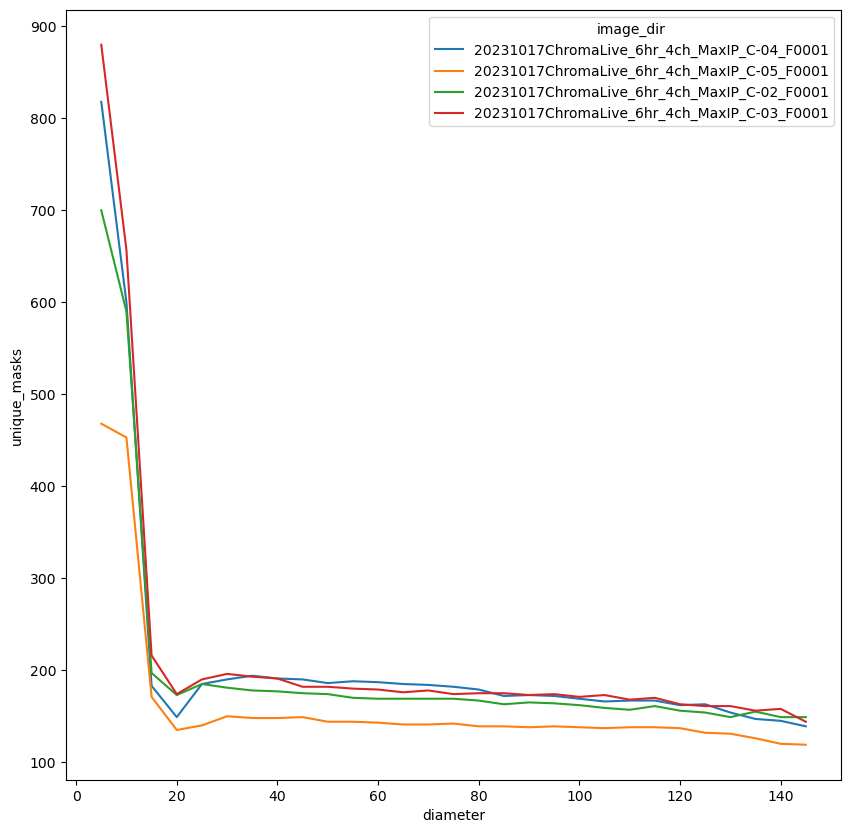

In [9]:
import seaborn as sns

# plot the nuumber of masks for each diameter
plt.figure(figsize=(10, 10))
# plt.lineplot(data=all_masks_df, x="diameter", y="unique_masks", hue="image_dir")
sns.lineplot(data=all_masks_df, x="diameter", y="unique_masks", hue="image_dir")

## Cellpose

In [ ]:
print("Best diameter: ", best_diameter)
print("Number of unique masks: ", np.max(unique_masks_dict["unique_masks"]))

plt.plot(unique_masks_dict["diameter"], unique_masks_dict["unique_masks"])
# plot a vertical line
plt.axvline(x=best_diameter, color="red", linestyle="--")
plt.xlabel("Diameter")
plt.ylabel("Number of unique masks")
plt.title("Number of unique masks vs Diameter")
if in_notebook:
    plt.show()
plt.savefig("../figures/unique_nuclei_masks_vs_diameter.png")

In [ ]:
# if not optimize_segmentation:
#     # model_type='cyto' or 'nuclei' or 'cyto2' or 'cyto3'
#     model_name = "nuclei"
#     model = models.Cellpose(model_type=model_name, gpu=True)

#     channels = [[1, 0]]

#     masks_all_dict = {"masks": [], "imgs": []}

#     # get masks for all the images
#     # save to a dict for later use
#     for img in nuclei:
#         img = normalize(img)
#         masks, flows, styles, diams = model.eval(img, channels=channels, diameter=50)

#         masks_all_dict["masks"].append(masks)
#         masks_all_dict["imgs"].append(img)
#     print(len(masks_all_dict))
#     masks_all = masks_all_dict["masks"]
#     imgs = masks_all_dict["imgs"]

#     masks_all = np.array(masks_all)
#     imgs = np.array(imgs)

#     for frame_index, frame in enumerate(image_dict["nuclei_file_paths"]):
#         tifffile.imwrite(
#             f"{input_dir}/{str(frame).split('/')[-1].split('_C4')[0]}_nuclei_mask.tiff",
#             masks_all[frame_index, :, :],
#         )
#     if in_notebook:
#         for z in range(len(masks_all)):
#             plt.figure(figsize=(20, 10))
#             plt.title(f"z: {z}")
#             plt.axis("off")
#             plt.subplot(1, 2, 1)
#             plt.imshow(nuclei[z], cmap="gray")
#             plt.title("Nuclei")
#             plt.axis("off")

#             plt.subplot(122)
#             plt.imshow(render_label(masks_all[z]))
#             plt.title("Cell masks")
#             plt.axis("off")
#             plt.show()

In [ ]:
# # set up memory profiler for GPU
# device = torch.device("cuda:0")
# free_after, total_after = torch.cuda.mem_get_info(device)
# amount_used = ((total_after - free_after)) / 1024**2
# print(f"Used: {amount_used} MB or {amount_used / 1024} GB of GPU RAM")